In [1]:
# Load libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob

# Network Libraries
import networkx as nx
from nxviz import CircosPlot
import community

# Libraries used for Topological Data Analysis 
import gudhi

# Possibility to stop warnings
import warnings

warnings.filterwarnings('ignore') 

In [ ]:
# MSDL connectivity matrices for nilearn connectome
dont run

import os
import sys
import pandas as pd
import numpy as np
import nibabel as nib
from nilearn import datasets
from nilearn.maskers import NiftiMapsMasker
from nilearn.connectome import ConnectivityMeasure
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Import your parameters
curr_dir = f'/user_data/csimmon2/git_repos/ptoc'
sys.path.insert(0, curr_dir)
import ptoc_params as params

# Set up directories and parameters
study = 'ptoc'
study_dir = f"/lab_data/behrmannlab/vlad/{study}"
raw_dir = params.raw_dir
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

# Load subject information
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subjects_to_skip = []
subs = sub_info[(sub_info['group'] == 'control') & (~sub_info['sub'].isin(subjects_to_skip))]['sub'].tolist()

run_num = 3
runs = list(range(1, run_num + 1))

def verify_standard_space(img):
    """Verify image is in 2mm standard space"""
    if img.shape[:3] != (91, 109, 91):
        logging.warning(f"Unexpected shape: {img.shape}")
        return False
    
    vox_size = np.sqrt(np.sum(img.affine[:3, :3] ** 2, axis=0))
    if not np.allclose(vox_size, [2., 2., 2.], atol=0.1):
        logging.warning(f"Unexpected voxel size: {vox_size}")
        return False
    
    return True

def create_connectivity_matrix(ss):
    """Create connectivity matrix using MSDL atlas"""
    logging.info(f"Processing subject: {ss}")
    
    # Load MSDL atlas
    atlas = datasets.fetch_atlas_msdl()
    atlas_img = atlas.maps
    
    all_runs_data = []
    
    for rn in runs:
        # Load standard space data
        run_path = f'{raw_dir}/{ss}/ses-01/derivatives/fsl/loc/run-0{rn}/1stLevel.feat/reg_standard/filtered_func_data_standard.nii.gz'
        if not os.path.exists(run_path):
            logging.warning(f'Standard space data not found: {run_path}')
            continue
        
        subject_img = nib.load(run_path)
        
        # Verify standard space
        if not verify_standard_space(subject_img):
            logging.warning(f"Data not in expected standard space for {ss} run-{rn}")
            continue
        
        # Extract time series using the MSDL atlas
        masker = NiftiMapsMasker(
            maps_img=atlas_img,
            standardize=True,
            memory='nilearn_cache',
            verbose=0
        )
        
        time_series = masker.fit_transform(subject_img)
        all_runs_data.append(time_series)
    
    if not all_runs_data:
        logging.warning(f'No valid run data found for subject {ss}')
        return None
    
    # Concatenate runs
    full_time_series = np.concatenate(all_runs_data, axis=0)
    
    # Compute connectivity matrix
    correlation_measure = ConnectivityMeasure(kind='correlation')
    connectivity_matrix = correlation_measure.fit_transform([full_time_series])[0]
    
    return connectivity_matrix

def main():
    # Create output directory if it doesn't exist
    output_dir = f'{results_dir}/connectivity_matrices_MSDL'
    os.makedirs(output_dir, exist_ok=True)
    
    # Process each subject
    for ss in subs:
        try:
            connectivity_matrix = create_connectivity_matrix(ss)
            if connectivity_matrix is not None:
                output_path = f'{output_dir}/{ss}_connectivity_matrix_MSDL.npy'
                np.save(output_path, connectivity_matrix)
                logging.info(f'Saved MSDL connectivity matrix for {ss} at {output_path}')
                logging.info(f'Matrix shape: {connectivity_matrix.shape}')  # Should be (39, 39) for MSDL
        except Exception as e:
            logging.error(f"Error processing subject {ss}: {str(e)}")
            continue

if __name__ == "__main__":
    main()

2024-11-12 10:42:17,969 - INFO - Processing subject: sub-025
2024-11-12 10:43:30,586 - INFO - Saved MSDL connectivity matrix for sub-025 at /user_data/csimmon2/git_repos/ptoc/results/connectivity_matrices_MSDL/sub-025_connectivity_matrix_MSDL.npy
2024-11-12 10:43:30,588 - INFO - Matrix shape: (39, 39)
2024-11-12 10:43:30,589 - INFO - Processing subject: sub-038
2024-11-12 10:44:29,157 - INFO - Saved MSDL connectivity matrix for sub-038 at /user_data/csimmon2/git_repos/ptoc/results/connectivity_matrices_MSDL/sub-038_connectivity_matrix_MSDL.npy
2024-11-12 10:44:29,159 - INFO - Matrix shape: (39, 39)
2024-11-12 10:44:29,160 - INFO - Processing subject: sub-057
2024-11-12 10:45:30,171 - INFO - Saved MSDL connectivity matrix for sub-057 at /user_data/csimmon2/git_repos/ptoc/results/connectivity_matrices_MSDL/sub-057_connectivity_matrix_MSDL.npy
2024-11-12 10:45:30,173 - INFO - Matrix shape: (39, 39)
2024-11-12 10:45:30,174 - INFO - Processing subject: sub-059
2024-11-12 10:46:31,143 - INFO

2024-11-13 12:05:17,963 - INFO - Loaded matrix for subject sub-025
2024-11-13 12:05:17,964 - INFO - Loaded matrix for subject sub-038
2024-11-13 12:05:17,966 - INFO - Loaded matrix for subject sub-057
2024-11-13 12:05:17,967 - INFO - Loaded matrix for subject sub-059
2024-11-13 12:05:17,969 - INFO - Loaded matrix for subject sub-064
2024-11-13 12:05:17,970 - INFO - Loaded matrix for subject sub-067
2024-11-13 12:05:17,971 - INFO - Loaded matrix for subject sub-068
2024-11-13 12:05:17,973 - INFO - Loaded matrix for subject sub-071
2024-11-13 12:05:17,974 - INFO - Loaded matrix for subject sub-083
2024-11-13 12:05:17,976 - INFO - Loaded matrix for subject sub-084
2024-11-13 12:05:17,977 - INFO - Loaded matrix for subject sub-085
2024-11-13 12:05:17,978 - INFO - Loaded matrix for subject sub-087
2024-11-13 12:05:17,980 - INFO - Loaded matrix for subject sub-088
2024-11-13 12:05:17,981 - INFO - Loaded matrix for subject sub-093
2024-11-13 12:05:17,983 - INFO - Loaded matrix for subject sub

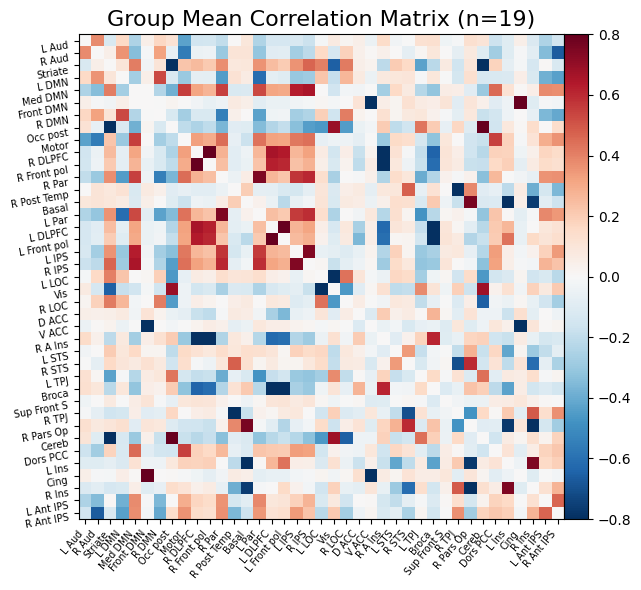

<Figure size 800x600 with 0 Axes>

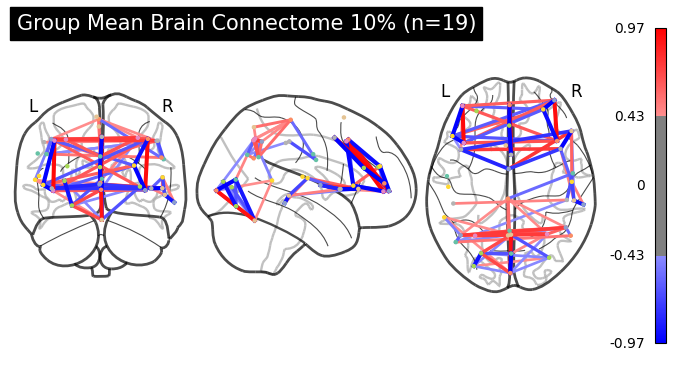

<Figure size 800x600 with 0 Axes>

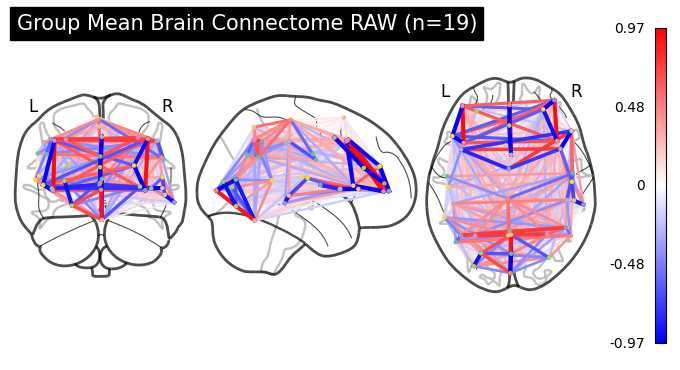


Group-Level Connectivity Statistics:
Number of subjects: 19
Shape: (39, 39)
Value range: [-0.966, 1.000]
Number of regions: 39


In [5]:
# MSDL connectivity visuals for nilearn connectome

import os
import numpy as np
from nilearn import datasets, plotting
import matplotlib.pyplot as plt
import pandas as pd
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load subject information
curr_dir = '/user_data/csimmon2/git_repos/ptoc'
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subjects_to_skip = []
subs = sub_info[(sub_info['group'] == 'control') & (~sub_info['sub'].isin(subjects_to_skip))]['sub'].tolist()

# Set up directories
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
matrix_dir = f'{results_dir}/connectivity_matrices_MSDL'

# Load MSDL atlas for labels and coordinates
atlas = datasets.fetch_atlas_msdl()
labels = atlas.labels
coords = atlas.region_coords

def load_all_matrices():
    """Load and average matrices across all subjects"""
    all_matrices = []
    
    for sub in subs:
        matrix_path = f'{matrix_dir}/{sub}_connectivity_matrix_MSDL.npy'
        if os.path.exists(matrix_path):
            try:
                matrix = np.load(matrix_path)
                all_matrices.append(matrix)
                logging.info(f"Loaded matrix for subject {sub}")
            except Exception as e:
                logging.error(f"Error loading matrix for {sub}: {str(e)}")
    
    if not all_matrices:
        raise ValueError("No matrices were successfully loaded")
    
    # Calculate mean and standard deviation across subjects
    mean_matrix = np.mean(all_matrices, axis=0)
    std_matrix = np.std(all_matrices, axis=0)
    
    return mean_matrix, std_matrix, len(all_matrices)

def create_group_visualizations(mean_matrix, std_matrix, n_subjects):
    """Create group-level visualizations"""
    # Plot 1: Correlation Matrix
    fig = plt.figure(figsize=(15, 6))
    
    ax1 = plt.subplot(121)
    matrix_plot = mean_matrix.copy()
    np.fill_diagonal(matrix_plot, 0)
    
    plotting.plot_matrix(
        matrix_plot,
        labels=labels,
        colorbar=True,
        vmax=0.8,
        vmin=-0.8,
        title=f'Group Mean Correlation Matrix (n={n_subjects})',
        axes=ax1
    )
    
    # Plot 2.1: Brain Connectome as separate figure
    fig_connectome = plt.figure(figsize=(8, 6))
    display = plotting.plot_connectome(
        mean_matrix,
        coords,
        edge_threshold="90%", # threshold only for plotting
        node_size=5,
        node_color='auto',
        colorbar=True,
        title=f'Group Mean Brain Connectome 10% (n={n_subjects})',
        display_mode='ortho'
    )
    # Plot 2.2: Brain Connectome as separate figure - RAW
    fig_connectome = plt.figure(figsize=(8, 6))
    display = plotting.plot_connectome(
        mean_matrix,
        coords,
        edge_threshold="0%", 
        node_size=5,
        node_color='auto',
        colorbar=True,
        title=f'Group Mean Brain Connectome RAW (n={n_subjects})',
        display_mode='ortho'
    )
    
    # Show both plots
    plt.show()
    
    # Create interactive 3D view
    view = plotting.view_connectome(
        mean_matrix,
        coords,
        edge_threshold="0%"
    )
    #view.open_in_browser()
    
    # Print connectivity statistics
    print("\nGroup-Level Connectivity Statistics:")
    print(f"Number of subjects: {n_subjects}")
    print(f"Shape: {mean_matrix.shape}")
    print(f"Value range: [{mean_matrix.min():.3f}, {mean_matrix.max():.3f}]")
    print(f"Number of regions: {len(labels)}")

def main():
    try:
        # Load and average all matrices
        mean_matrix, std_matrix, n_subjects = load_all_matrices()
        
        # Create group-level visualizations
        create_group_visualizations(mean_matrix, std_matrix, n_subjects)
        
    except Exception as e:
        logging.error(f"Error in main execution: {str(e)}")

if __name__ == "__main__":
    main()

2024-11-13 12:06:39,671 - INFO - Loaded matrix for subject sub-025
2024-11-13 12:06:39,672 - INFO - Loaded matrix for subject sub-038
2024-11-13 12:06:39,674 - INFO - Loaded matrix for subject sub-057
2024-11-13 12:06:39,676 - INFO - Loaded matrix for subject sub-059
2024-11-13 12:06:39,677 - INFO - Loaded matrix for subject sub-064
2024-11-13 12:06:39,679 - INFO - Loaded matrix for subject sub-067
2024-11-13 12:06:39,680 - INFO - Loaded matrix for subject sub-068
2024-11-13 12:06:39,682 - INFO - Loaded matrix for subject sub-071
2024-11-13 12:06:39,683 - INFO - Loaded matrix for subject sub-083
2024-11-13 12:06:39,685 - INFO - Loaded matrix for subject sub-084
2024-11-13 12:06:39,686 - INFO - Loaded matrix for subject sub-085
2024-11-13 12:06:39,688 - INFO - Loaded matrix for subject sub-087
2024-11-13 12:06:39,689 - INFO - Loaded matrix for subject sub-088
2024-11-13 12:06:39,691 - INFO - Loaded matrix for subject sub-093
2024-11-13 12:06:39,692 - INFO - Loaded matrix for subject sub


Group-Level Connectivity Statistics:
Number of subjects: 19
Matrix shape: (39, 39)
Mean correlation range: [-0.966, 1.000]
Standard deviation range: [0.000, 0.423]

ROI-specific connections:
L LOC <-> R LOC: 0.431 ± 0.200
L LOC <-> L IPS: -0.057 ± 0.423
L LOC <-> R IPS: 0.014 ± 0.354
L LOC <-> L Ant IPS: -0.122 ± 0.225
L LOC <-> R Ant IPS: -0.214 ± 0.221
R LOC <-> L IPS: -0.104 ± 0.299
R LOC <-> R IPS: -0.080 ± 0.396
R LOC <-> L Ant IPS: -0.154 ± 0.212
R LOC <-> R Ant IPS: -0.270 ± 0.215
L IPS <-> R IPS: 0.743 ± 0.110
L IPS <-> L Ant IPS: 0.183 ± 0.204
L IPS <-> R Ant IPS: 0.342 ± 0.180
R IPS <-> L Ant IPS: 0.274 ± 0.181
R IPS <-> R Ant IPS: 0.228 ± 0.246
L Ant IPS <-> R Ant IPS: 0.468 ± 0.194


<Figure size 640x480 with 0 Axes>

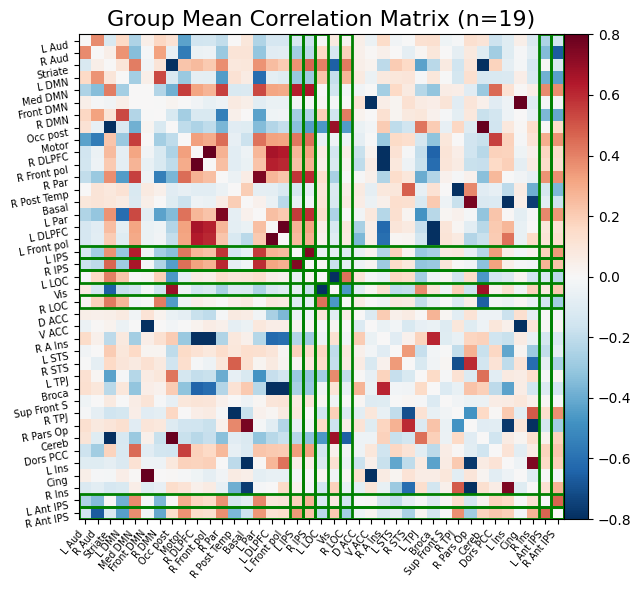

In [6]:
#highlight roi
import os
import numpy as np
from nilearn import datasets, plotting
import matplotlib.pyplot as plt
import pandas as pd
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load subject information
curr_dir = '/user_data/csimmon2/git_repos/ptoc'
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subjects_to_skip = []
subs = sub_info[(sub_info['group'] == 'control') & (~sub_info['sub'].isin(subjects_to_skip))]['sub'].tolist()

# Set up directories
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
matrix_dir = f'{results_dir}/connectivity_matrices_MSDL'

# Load MSDL atlas for labels and coordinates
atlas = datasets.fetch_atlas_msdl()
labels = atlas.labels
coords = atlas.region_coords

def create_group_visualizations(mean_matrix, std_matrix, n_subjects):
    
    """Create group-level visualizations with highlighted ROIs"""
    # Explicitly create a new figure
    plt.clf()  # Clear any existing figures
    fig = plt.figure(figsize=(15, 6))
    
    # Plot 1: Mean Correlation Matrix
    ax1 = plt.subplot(121)
    matrix_plot = mean_matrix.copy()
    np.fill_diagonal(matrix_plot, 0)
    
    # Create ROI indices with correct MSDL atlas labels
    roi_names = ['L LOC', 'R LOC', 'L IPS', 'R IPS', 'L Ant IPS', 'R Ant IPS']
    roi_indices = [labels.index(roi) for roi in roi_names]
    
    # Plot the matrix
    plotting.plot_matrix(
        matrix_plot,
        labels=labels,
        colorbar=True,
        vmax=0.8,
        vmin=-0.8,
        title=f'Group Mean Correlation Matrix (n={n_subjects})',
        axes=ax1
    )
    
    # Add highlighting for ROIs
    n_labels = len(labels)
    for idx in roi_indices:
        # Highlight row
        ax1.add_patch(plt.Rectangle((-0.5, idx - 0.5), n_labels, 1, 
                                  fill=False, edgecolor='green', lw=2))
        # Highlight column
        ax1.add_patch(plt.Rectangle((idx - 0.5, -0.5), 1, n_labels, 
                                  fill=False, edgecolor='green', lw=2))
    
    # Save the correlation matrix plot
    #plt.savefig(f'{results_dir}/msdl_correlation_matrix_highlighted.png', 
                #dpi=300, bbox_inches='tight')
    
    # Create interactive 3D view
    view = plotting.view_connectome(
        mean_matrix,
        coords,
        edge_threshold="80%"
    )
    #view.open_in_browser()
    
    # Print group-level statistics
    print("\nGroup-Level Connectivity Statistics:")
    print(f"Number of subjects: {n_subjects}")
    print(f"Matrix shape: {mean_matrix.shape}")
    print(f"Mean correlation range: [{mean_matrix.min():.3f}, {mean_matrix.max():.3f}]")
    print(f"Standard deviation range: [{std_matrix.min():.3f}, {std_matrix.max():.3f}]")
    
    # Add specific analysis of ROI connections
    print("\nROI-specific connections:")
    for i, roi1 in enumerate(roi_names):
        idx1 = labels.index(roi1)
        for roi2 in roi_names[i+1:]:
            idx2 = labels.index(roi2)
            correlation = mean_matrix[idx1, idx2]
            std = std_matrix[idx1, idx2]
            print(f"{roi1} <-> {roi2}: {correlation:.3f} ± {std:.3f}")\

def main():
    try:
        # Load and average all matrices
        mean_matrix, std_matrix, n_subjects = load_all_matrices()
        
        # Create group-level visualizations
        create_group_visualizations(mean_matrix, std_matrix, n_subjects)
        
    except Exception as e:
        logging.error(f"Error in main execution: {str(e)}")

if __name__ == "__main__":
    main()

In [ ]:
# groups sparse covariance [group thresholding]

import os
import numpy as np
import pandas as pd
from nilearn import datasets, plotting
from nilearn.maskers import NiftiMapsMasker
from nilearn.connectome import GroupSparseCovarianceCV
import matplotlib.pyplot as plt
import ptoc_params as params

def setup_directories(base_dir):
    """Setup directory structure for results"""
    results_dir = f'{base_dir}/results/connectivity_analysis'
    os.makedirs(results_dir, exist_ok=True)
    return results_dir

def extract_time_series(subject, run, atlas):
    """Extract time series data for a single run using MSDL atlas"""
    run_path = f'{params.raw_dir}/{subject}/ses-01/derivatives/fsl/loc/run-0{run}/1stLevel.feat/reg_standard/filtered_func_data_standard.nii.gz'
    
    if not os.path.exists(run_path):
        return None
        
    masker = NiftiMapsMasker(
        maps_img=atlas.maps,
        resampling_target="maps",
        detrend=True,
        high_variance_confounds=True,
        low_pass=None,
        high_pass=0.01,
        t_r=2,
        standardize="zscore_sample",
        standardize_confounds="zscore_sample",
        memory="nilearn_cache",
        memory_level=1
    )
    
    return masker.fit_transform(run_path)

def prepare_subject_data(subjects, atlas):
    """Prepare data for all subjects"""
    all_subjects_data = []
    valid_subjects = []
    
    for subject in subjects:
        all_runs = []
        for run in range(1, 4):
            time_series = extract_time_series(subject, run, atlas)
            if time_series is not None:
                if not (np.isnan(time_series).any() or np.isinf(time_series).any()):
                    all_runs.append(time_series)
        
        if all_runs:
            subject_data = np.concatenate(all_runs, axis=0)
            all_subjects_data.append(subject_data)
            valid_subjects.append(subject)
    
    return all_subjects_data, valid_subjects

def plot_group_matrices(covariance, precision, atlas_labels, results_dir):
    """Plot group-level covariance and precision matrices"""
    plot_precision = precision.copy()
    np.fill_diagonal(plot_precision, 0)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    plotting.plot_matrix(
        covariance,
        labels=atlas_labels,
        axes=ax1,
        title='Group Covariance Matrix',
        colorbar=True
    )
    
    plotting.plot_matrix(
        plot_precision,
        labels=atlas_labels,
        axes=ax2,
        title='Group Precision Matrix',
        colorbar=True
    )
    
    plt.tight_layout()
    plt.savefig(f'{results_dir}/group_matrices.png')
    #plt.close()

def main():
    """Run group analysis pipeline"""
    curr_dir = '/user_data/csimmon2/git_repos/ptoc'
    results_dir = setup_directories(curr_dir)
    
    sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
    subjects_to_skip = []
    subs = sub_info[
        (sub_info['group'] == 'control') & 
        (~sub_info['sub'].isin(subjects_to_skip))
    ]['sub'].tolist()
    
    atlas = datasets.fetch_atlas_msdl()
    
    try:
        subjects_data, valid_subjects = prepare_subject_data(subs, atlas)
        
        if len(subjects_data) < 2:
            raise ValueError("Need at least 2 subjects for group analysis")
            
        estimator = GroupSparseCovarianceCV()
        estimator.fit(subjects_data)
        
        np.save(f'{results_dir}/group_covariance.npy', estimator.covariance)
        np.save(f'{results_dir}/group_precision.npy', estimator.precision)
        
        plot_group_matrices(
            estimator.covariance,
            estimator.precision,
            atlas.labels,
            results_dir
        )
        
    except Exception as e:
        print(f"Error in execution: {str(e)}")
        raise

if __name__ == "__main__":
    main()

In [ ]:
# Visualize group connectome from group sparse covariance group thresholding
from nilearn import datasets, plotting
import matplotlib.pyplot as plt

# Load MSDL atlas coordinates
atlas = datasets.fetch_atlas_msdl()
coords = atlas.region_coords

# Create connectome plot
plt.figure(figsize=(15, 5))
display = plotting.plot_connectome(
    estimator.precision,  # Using precision matrix from earlier analysis
    coords,
    edge_threshold=None,  # No additional thresholding
    node_color='auto',
    display_mode='lyr',
    node_size=2,
    title='Group-Level Brain Connectome'
)
plt.show()  # For interactive display in notebook

Group analysis complete!
Matrix shape: (39, 39)
Number of connections: 225
Alpha value used: 0.01441309106513833


<Figure size 1500x500 with 0 Axes>

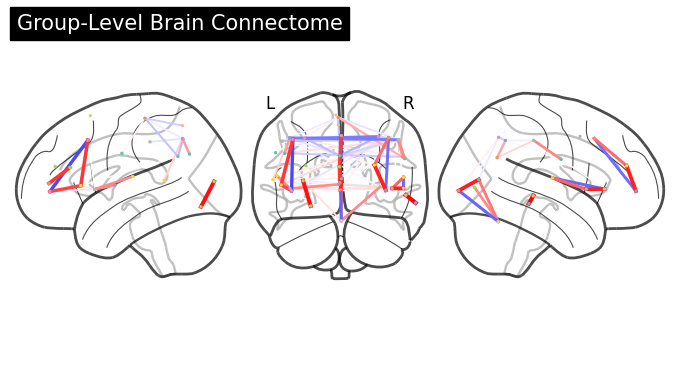

In [13]:
# Graphical Lasso CV group analysis [?]
import os
import numpy as np
from nilearn import datasets, plotting
import matplotlib.pyplot as plt
from sklearn.covariance import GraphicalLassoCV

# Load MSDL atlas
atlas = datasets.fetch_atlas_msdl()
coords = atlas.region_coords

# Directory with covariance matrices
results_dir = '/user_data/csimmon2/git_repos/ptoc/results/connectivity_analysis'

# Get all covariance matrix files
covariance_files = [f for f in os.listdir(f'{results_dir}/individual') if f.startswith('covariance_')]

# Load and combine all subjects' covariance matrices
all_covariances = []
for cfile in covariance_files:
    cov = np.load(f'{results_dir}/individual/{cfile}')
    all_covariances.append(cov)

# Convert to array and take mean
mean_covariance = np.mean(all_covariances, axis=0)

# Fit GraphicalLassoCV to get group-level precision matrix
estimator = GraphicalLassoCV()
estimator.fit(mean_covariance)  # Pass the mean covariance directly

# Get the group precision matrix
group_precision = estimator.precision_

# Create connectome plot
plt.figure(figsize=(15, 5))
display = plotting.plot_connectome(
    group_precision,
    coords,
    edge_threshold=None,  # No additional thresholding
    node_color='auto',
    display_mode='lyr',
    node_size=2,
    title='Group-Level Brain Connectome'
)
#plt.savefig(f'{results_dir}/group_connectome.png')
#plt.close()

print("Group analysis complete!")
print(f"Matrix shape: {group_precision.shape}")
print(f"Number of connections: {np.sum(group_precision != 0)}")
print(f"Alpha value used: {estimator.alpha_}")


<Figure size 1000x800 with 0 Axes>

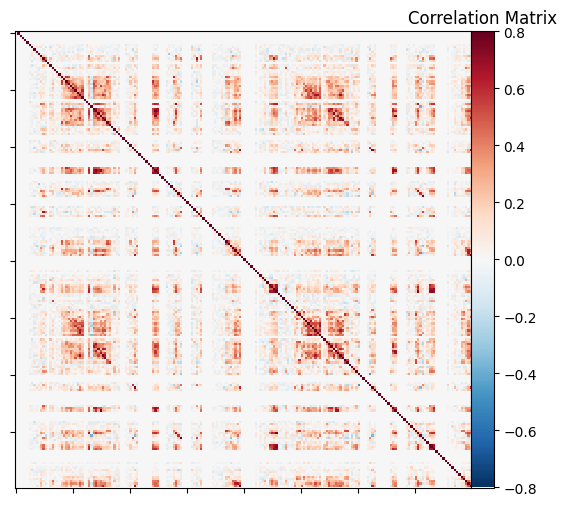

<Figure size 1500x800 with 0 Axes>

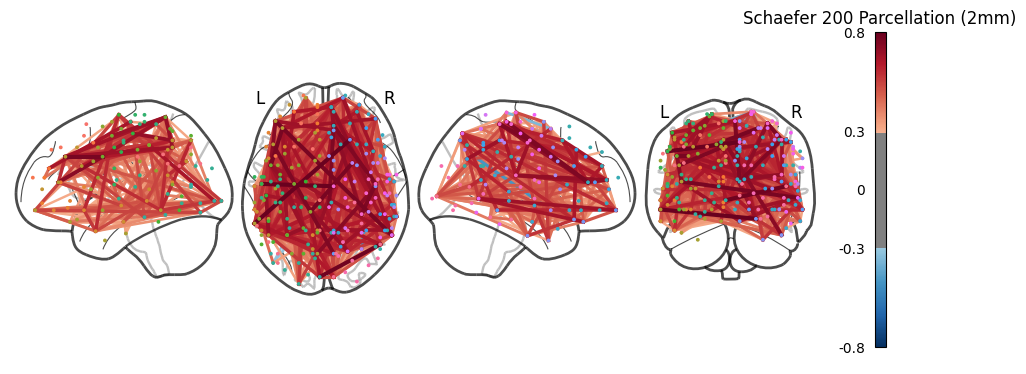

<Figure size 1500x800 with 0 Axes>

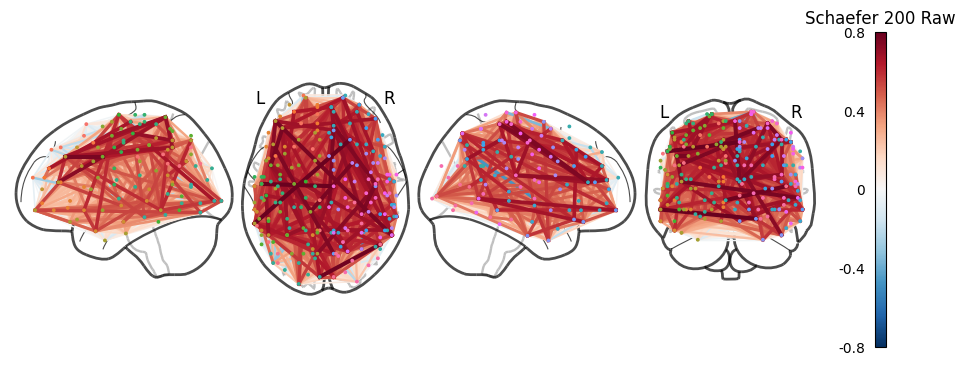


Connectivity Statistics:
Mean absolute connectivity: 0.061
Max positive connectivity: 0.792
Max negative connectivity: -0.471

Strongest Positive Connections:
ROI 7networks_RH_DorsAttn_TempOcc_4 <-> ROI 7networks_LH_Vis_Striate_2: 0.776
ROI 7networks_RH_Limbic_OFC_2 <-> ROI 7networks_LH_Cont_Temp: 0.791
ROI 7networks_LH_Cont_Temp <-> ROI 7networks_RH_Limbic_OFC_2: 0.791
ROI 7networks_LH_SomMot_12 <-> ROI 7networks_RH_SomMot_5: 0.792
ROI 7networks_RH_SomMot_5 <-> ROI 7networks_LH_SomMot_12: 0.792


In [ ]:
# remapping schaefer 200 atlas to work with nilearn glass brain # single subject

import numpy as np
import pandas as pd
from nilearn import datasets, plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Load your correlation matrix
matrix_path = '/user_data/csimmon2/git_repos/ptoc/results/connectivity_matrices_200_standard/sub-107_connectivity_matrix_standard.npy'
correlation_matrix = np.load(matrix_path)

# Load coordinates with the correct 2mm path
coords_path = 'analyses/network/200Parcels_Yeo2011_7Networks_FSLMNI152_2mm.csv'
coords_df = pd.read_csv(coords_path)
coords = coords_df[['R', 'A', 'S']].values

# Generate random colors
node_colors = sns.color_palette('husl', n_colors=200)

# Create two separate figures for better control
# Figure 1: Matrix
plt.figure(figsize=(10, 8))
plotting.plot_matrix(
    correlation_matrix,
    colorbar=True,
    vmax=0.8,
    vmin=-0.8,
    cmap='RdBu_r'
)
plt.title('Correlation Matrix')
plt.show()

# Figure 2: Brain Connectome
plt.figure(figsize=(15, 8))
plotting.plot_connectome(
    correlation_matrix,
    coords,
    edge_threshold='95%',
    node_size=3,
    node_color=node_colors,
    display_mode='lzry',
    edge_vmin=-0.8,
    edge_vmax=0.8,
    colorbar=True,
    edge_cmap='RdBu_r'
)
plt.title('Schaefer 200 Parcellation (2mm)')
plt.show()

# Figure 2.1: Brain Connectome
plt.figure(figsize=(15, 8))
plotting.plot_connectome(
    correlation_matrix,
    coords,
    edge_threshold='0%',
    node_size=3,
    node_color=node_colors,
    display_mode='lzry',
    edge_vmin=-0.8,
    edge_vmax=0.8,
    colorbar=True,
    edge_cmap='RdBu_r'
)
plt.title('Schaefer 200 Raw')
plt.show()

# Print statistics
print("\nConnectivity Statistics:")
np.fill_diagonal(correlation_matrix, 0)  # Remove diagonal for stats
print(f"Mean absolute connectivity: {np.mean(np.abs(correlation_matrix)):.3f}")
print(f"Max positive connectivity: {np.max(correlation_matrix):.3f}")
print(f"Max negative connectivity: {np.min(correlation_matrix):.3f}")

# Show strongest connections
print("\nStrongest Positive Connections:")
top_positive = np.unravel_index(np.argsort(correlation_matrix.ravel())[-5:], correlation_matrix.shape)
for i, j in zip(top_positive[0], top_positive[1]):
    if i != j:  # Skip diagonal
        print(f"ROI {coords_df['ROI Name'][i]} <-> ROI {coords_df['ROI Name'][j]}: {correlation_matrix[i,j]:.3f}")

Successfully averaged 19 subjects

Group Connectivity Statistics:
Mean absolute connectivity: 0.060
Max positive connectivity: 0.851
Max negative connectivity: -0.242
Standard deviation: 0.120

Analysis complete! Results saved in 'group_connectivity_analysis' directory


<Figure size 1200x1000 with 0 Axes>

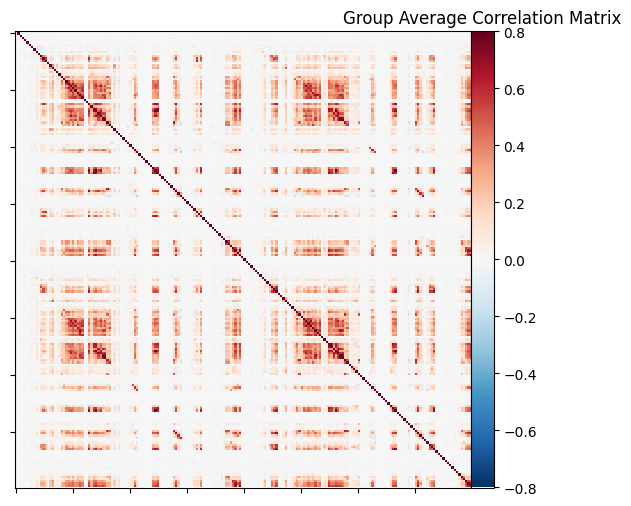

<Figure size 1500x800 with 0 Axes>

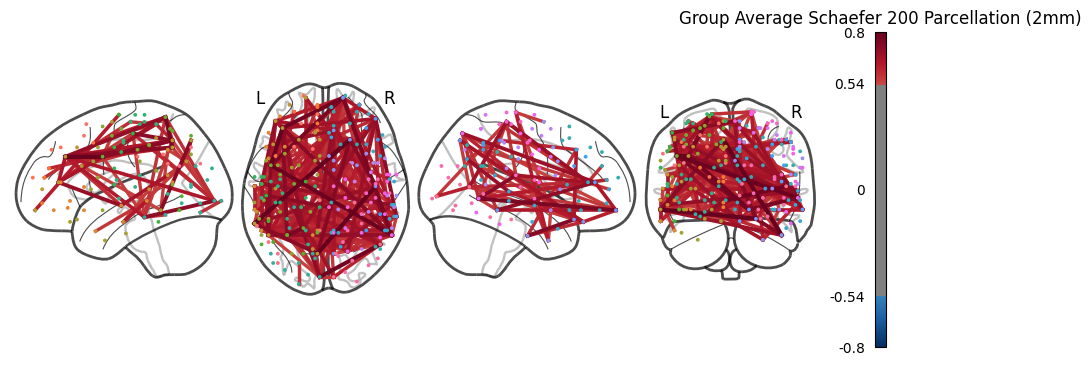

<Figure size 1500x800 with 0 Axes>

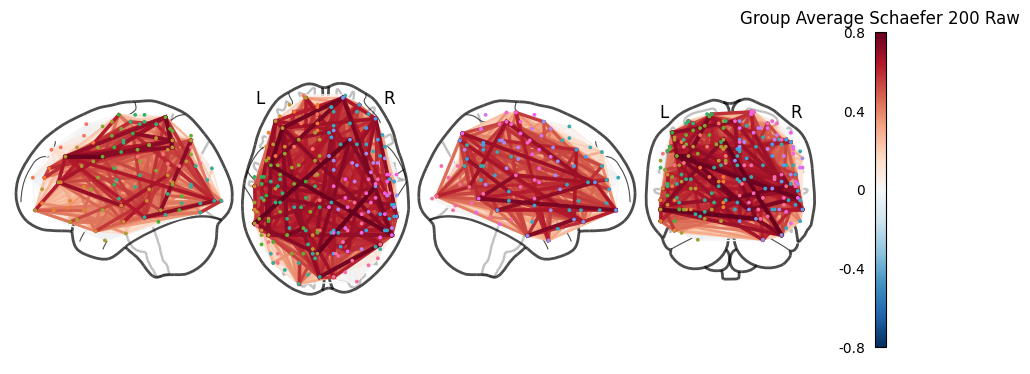

In [ ]:
# remapping schaefer 200 atlas to work with nilearn glass brain # group level 

import numpy as np
import pandas as pd
from nilearn import datasets, plotting
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

def load_and_average_matrices(subs, base_path):
    """Load and average correlation matrices for all subjects."""
    
    # Initialize with first subject to get dimensions
    first_matrix = np.load(f'{base_path}/{subs[0]}_connectivity_matrix_standard.npy')
    avg_matrix = np.zeros_like(first_matrix)
    
    valid_subjects = []
    for sub in subs:
        try:
            matrix_path = f'{base_path}/{sub}_connectivity_matrix_standard.npy'
            curr_matrix = np.load(matrix_path)
            avg_matrix += curr_matrix
            valid_subjects.append(sub)
        except Exception as e:
            print(f"Error loading subject {sub}: {str(e)}")
    
    avg_matrix /= len(valid_subjects)
    print(f"Successfully averaged {len(valid_subjects)} subjects")
    return avg_matrix

def analyze_group_connectivity(correlation_matrix, coords_df, output_dir):
    """Analyze group-level connectivity and save results."""
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Get coordinates
    coords = coords_df[['R', 'A', 'S']].values
    
    # Generate random colors
    node_colors = sns.color_palette('husl', n_colors=200)
    
    # Figure 1: Group Average Matrix
    plt.figure(figsize=(12, 10))
    matrix_plot = plotting.plot_matrix(
        correlation_matrix,
        colorbar=True,
        vmax=0.8,
        vmin=-0.8,
        cmap='RdBu_r'
    )
    plt.title('Group Average Correlation Matrix')
    #plt.savefig(output_dir / 'group_correlation_matrix.png', dpi=300, bbox_inches='tight')
    #plt.close()
    
    # Figure 2: Thresholded Group Brain Connectome
    plt.figure(figsize=(15, 8))
    plotting.plot_connectome(
        correlation_matrix,
        coords,
        edge_threshold='99%',
        node_size=3,
        node_color=node_colors,
        display_mode='lzry',
        edge_vmin=-0.8,
        edge_vmax=0.8,
        colorbar=True,
        edge_cmap='RdBu_r'
    )
    plt.title('Group Average Schaefer 200 Parcellation (2mm)')
    #plt.savefig(output_dir / 'group_connectome_thresholded.png', dpi=300, bbox_inches='tight')
    #plt.close()
    
    # Figure 3: Raw Group Brain Connectome
    plt.figure(figsize=(15, 8))
    plotting.plot_connectome(
        correlation_matrix,
        coords,
        edge_threshold='0%',
        node_size=3,
        node_color=node_colors,
        display_mode='lzry',
        edge_vmin=-0.8,
        edge_vmax=0.8,
        colorbar=True,
        edge_cmap='RdBu_r'
    )
    plt.title('Group Average Schaefer 200 Raw')
    #plt.savefig(output_dir / 'group_connectome_raw.png', dpi=300, bbox_inches='tight')
    #plt.close()
    
    # Calculate and save statistics
    matrix_no_diag = correlation_matrix.copy()
    np.fill_diagonal(matrix_no_diag, 0)
    
    stats = {
        'mean_abs_connectivity': np.mean(np.abs(matrix_no_diag)),
        'max_positive_connectivity': np.max(matrix_no_diag),
        'max_negative_connectivity': np.min(matrix_no_diag),
        'std_connectivity': np.std(matrix_no_diag)
    }
    
    # Get strongest connections
    top_positive = np.unravel_index(np.argsort(matrix_no_diag.ravel())[-10:], matrix_no_diag.shape)
    strong_connections = []
    for i, j in zip(top_positive[0], top_positive[1]):
        if i != j:
            connection = {
                'roi1': coords_df['ROI Name'][i],
                'roi2': coords_df['ROI Name'][j],
                'correlation': matrix_no_diag[i,j]
            }
            strong_connections.append(connection)
    
    # Save statistics and strong connections
    stats_df = pd.DataFrame([stats])
    
    connections_df = pd.DataFrame(strong_connections)
    connections_df.sort_values('correlation', ascending=False, inplace=True)
    
    # Print summary
    print("\nGroup Connectivity Statistics:")
    print(f"Mean absolute connectivity: {stats['mean_abs_connectivity']:.3f}")
    print(f"Max positive connectivity: {stats['max_positive_connectivity']:.3f}")
    print(f"Max negative connectivity: {stats['max_negative_connectivity']:.3f}")
    print(f"Standard deviation: {stats['std_connectivity']:.3f}")
    

def main():
    # Set up paths
    curr_dir = os.getcwd()
    matrix_base_path = '/user_data/csimmon2/git_repos/ptoc/results/connectivity_matrices_200_standard'
    
    # Load subject information
    sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
    subjects_to_skip = []
    subs = sub_info[(sub_info['group'] == 'control') & 
                    (~sub_info['sub'].isin(subjects_to_skip))]['sub'].tolist()
    
    # Load coordinates
    coords_df = pd.read_csv('analyses/network/200Parcels_Yeo2011_7Networks_FSLMNI152_2mm.csv')
    
    # Load and average correlation matrices
    avg_matrix = load_and_average_matrices(subs, matrix_base_path)
    
    # Analyze group connectivity
    output_dir = 'group_connectivity_analysis'
    analyze_group_connectivity(avg_matrix, coords_df, output_dir)
    
    print("\nAnalysis complete! Results saved in 'group_connectivity_analysis' directory")

if __name__ == "__main__":
    main()

In [ ]:
# load data - may be vestigal
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import os

def load_matrices_simple(results_dir, n_rois=200):
    """
    Simple function to load and average connectivity matrices
    
    Parameters:
    results_dir (str): Directory containing connectivity matrices
    n_rois (int): Number of ROIs (200 or 400)
    
    Returns:
    tuple: (averaged_matrix, region_labels)
    """
    # Load all individual matrices
    #matrix_files = glob.glob(f'{results_dir}/connectivity_matrices_{n_rois}/*_connectivity_matrix.npy')
    matrix_files = glob.glob(f'{results_dir}/connectivity_matrices/*[!glasser]_connectivity_matrix.npy') #!glasser to exclude glasser matrices
    
    if not matrix_files:
        raise FileNotFoundError(f"No connectivity matrices found in {results_dir}/connectivity_matrices_{n_rois}/")
    
    print(f"Found {len(matrix_files)} connectivity matrices")
    
    # Load and average matrices
    matrices = [np.load(file) for file in matrix_files]
    matrix = np.mean(matrices, axis=0)
    
    # Create simple region labels
    region_labels = [f"Region_{i+1}" for i in range(n_rois)]
    
    return matrix, region_labels


# Set up paths
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'

# Create figures directory if it doesn't exist
#os.makedirs(f'{results_dir}/figures', exist_ok=True)

# Load 200 ROI data
matrix, region_labels = load_matrices_simple(results_dir, n_rois=200)

# Now you can proceed with the visualization functions